In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('NSDUH_2016_Tab.tsv', sep='\t')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (2506) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
mydata = data[['IRSEX', 'CATAGE', 'NEWRACE2', 'INCOME', 'IRWRKSTAT', 'EDUSCHLGO', 'DIFFTHINK','DIFFWALK', 'DIFFDRESS', 'DIFFERAND', 'K6SCMON', 'ALCTRY', 'MJEVER', 'HEALTH','UDPYOPI']]
mydata = mydata.rename(index = str, columns = {"IRSEX": "gender", "CATAGE": "age","NEWRACE2":"race", "INCOME":"income"
                                           ,
                'IRWRKSTAT':'employment', 'EDUSCHLGO':'education', 'DIFFTHINK':'diffthink', 'DIFFWALK':'diffwalk'
                                              ,
                  "DIFFDRESS": "diffdress", "DIFFERAND": "differrand", "K6SCMON":"k6 score", "ALCTRY":"alcohol"
                                             ,
                 "MJEVER": "marijuana", "HEALTH": "overall health", "UDPYOPI":"oud"             
                                              }) 

In [4]:
import collections
collections.Counter(mydata['oud'])

Counter({0: 56348, 1: 549})

In [5]:
mydata1 = pd.get_dummies(mydata, columns = ["gender", "race"])

In [6]:
mydata1 = mydata1[mydata1['education'] < 3]

In [7]:
mydata1.shape

(56207, 22)

In [8]:
mydata1 = pd.get_dummies(mydata1, columns = ["education"])

In [9]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [10]:
float_array = mydata1['age'].values.astype(float)
scaled_array = min_max_scaler.fit_transform(float_array.reshape(-1, 1))
mydata1['age'] = scaled_array

In [11]:
float_array = mydata1['income'].values.astype(float)
scaled_array = min_max_scaler.fit_transform(float_array.reshape(-1, 1))
mydata1['income'] = scaled_array
#mydata1

In [12]:
mydata1 = mydata1[mydata1['marijuana'] < 3]

In [13]:
mydata1 = pd.get_dummies(mydata1, columns = ["marijuana"])
mydata1.head()

,age,income,employment,diffthink,diffwalk,diffdress,differrand,k6 score,alcohol,overall health,...,race_2,race_3,race_4,race_5,race_6,race_7,education_1,education_2,marijuana_1,marijuana_2
0,0.666667,1.000000,4,2,2,2,2,4.0,15,1,...,0,0,0,0,0,0,0,1,1,0
1,0.333333,1.000000,4,2,2,2,2,18.0,15,3,...,0,0,0,0,0,1,0,1,1,0
2,1.000000,0.333333,3,2,2,2,2,0.0,16,1,...,0,0,0,0,0,1,0,1,0,1
3,0.000000,1.000000,2,2,2,2,2,NaN,991,1,...,0,0,0,0,0,1,1,0,0,1
4,1.000000,0.666667,2,2,2,2,2,3.0,18,2,...,0,0,0,0,0,0,0,1,1,0


In [14]:
from sklearn.model_selection import StratifiedShuffleSplit
x = mydata1[["age","income","gender_1", "gender_2","race_1", "race_2", "race_3" , "race_4","race_5", "race_6", "race_7", "education_1", "education_2", "marijuana_1", "marijuana_2"]]
y = mydata1['oud']
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(x, y)
for train_index, test_index in sss.split(x, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    from sklearn.linear_model import LogisticRegression
    import sklearn
    #import sklearn.SVM
    from sklearn.neural_network import MLPClassifier

    logreg = MLPClassifier()
    results = logreg.fit(x_train, y_train)

    from sklearn.metrics import auc

    # apply the model to test data
    y_val_predict = logreg.predict(x_test)
    y_val_proba = logreg.predict_proba(x_test)
# data_train, data_val = train_test_split(mydata1, test_size = 0.20, random_state = 0, stratify = mydata1['oud'])
# y_train = data_train['oud']
# y_val = data_val['oud']

# # only features 
# X_train = data_train[["age","income","gender_1", "gender_2","race_1", "race_2", "race_3" , "race_4","race_5", "race_6", "race_7", "education_1", "education_2"]]
# X_val = data_val[["age","income","gender_1", "gender_2","race_1", "race_2", "race_3" , "race_4","race_5", "race_6", "race_7", "education_1", "education_2"]]


# print(y_train.sum())



TRAIN: [23312  4614 38782 ... 19255  3601 29131] TEST: [46818 12207 44882 ... 36499  3604 48438]


In [16]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            this_xs = this_xs.reindex(np.random.permutation(this_xs.index))

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = pd.concat(xs)
    ys = pd.Series(data=np.concatenate(ys),name='target')

    return xs,ys


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(216,)
(216, 2)
AUC:  0.8351766117969821


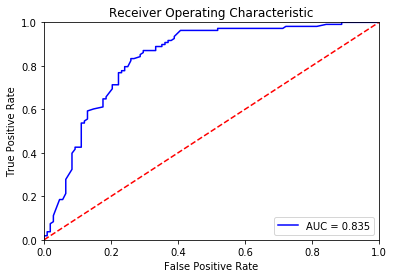

              precision    recall  f1-score   support

         0.0       0.76      0.77      0.77       106
         1.0       0.78      0.76      0.77       110

   micro avg       0.77      0.77      0.77       216
   macro avg       0.77      0.77      0.77       216
weighted avg       0.77      0.77      0.77       216

0.7685185185185185


In [18]:
import numpy as np
xs, ys = balanced_subsample(x,y)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(xs, ys)
for train_index, test_index in sss.split(xs, ys):
    #print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = xs.iloc[train_index], xs.iloc[test_index]
    #print(y_train.sum())
    y_train, y_test = ys.iloc[train_index], ys.iloc[test_index]
    
    from sklearn.linear_model import LogisticRegression
    import sklearn
    #import sklearn.SVM
    from sklearn.neural_network import MLPClassifier

    logreg = MLPClassifier()
    results = logreg.fit(x_train, y_train)

    from sklearn.metrics import auc

    # apply the model to test data
    y_val_predict = logreg.predict(x_test)
    y_val_proba = logreg.predict_proba(x_test)
from sklearn import metrics
from sklearn.metrics import confusion_matrix
print(y_test.shape)
print(y_val_proba.shape)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_val_proba[:,1])

# Calculate the area under the ROC curve
roc_auc = metrics.auc(fpr, tpr)
print('AUC: ',roc_auc)

#Plot ROC
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
#print(len(y_test))
#print(np.array(y_test))
#print(y_val_proba[:,1].round())
test = np.array(y_test)
pred = y_val_proba[:,1].round()
print(metrics.classification_report(pred, test))
print(metrics.accuracy_score(pred, test))

(216,)
(216, 2)
AUC:  0.8351766117969821


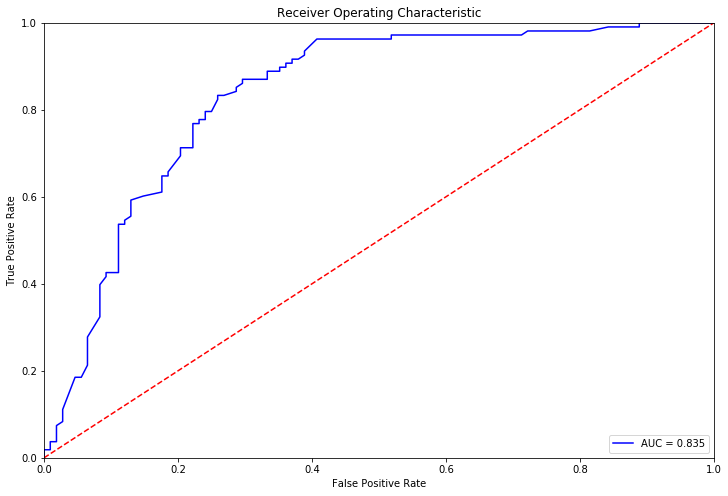

              precision    recall  f1-score   support

         0.0       0.76      0.77      0.77       106
         1.0       0.78      0.76      0.77       110

   micro avg       0.77      0.77      0.77       216
   macro avg       0.77      0.77      0.77       216
weighted avg       0.77      0.77      0.77       216

testing accuracy:  0.7685185185185185


In [19]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
print(y_test.shape)
print(y_val_proba.shape)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_val_proba[:,1])

# Calculate the area under the ROC curve
roc_auc = metrics.auc(fpr, tpr)
print('AUC: ',roc_auc)

#Plot ROC
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
#print(len(y_test))
#print(np.array(y_test))
#print(y_val_proba[:,1].round())
test = np.array(y_test)
pred = y_val_proba[:,1].round()
print(metrics.classification_report(pred, test))
print('testing accuracy: ', metrics.accuracy_score(pred, test))